# **Project: Multitask Learning for Geometric Shape Classification and Counting**

## 1. Overview

In this project, you will design, implement, and evaluate a **multitask neural network** that performs **two tasks simultaneously**:

1. **Classification** – identify which pair of geometric shape types appears in a 28×28 binary image (135 possible configurations).
2. **Regression** – predict how many shapes of each type are present (6 regression targets).

This project focuses on **multi-task learning**, i.e., using one shared model to learn several related tasks at once. You will compare how adding an auxiliary task affects performance and training dynamics.

---

## 2. Dataset

You will use the **Geometric Shape Numbers (GSN)** dataset:

```bash
!wget https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip
```

This will create a directory `data/` containing:

* **10,000 images** (28×28x1, grayscale)
* **labels.csv** – counts of each of six shape types per image

Each image contains exactly **two types** of geometric figures (out of six) and **10 shapes total**.

**Shape classes:**

| Index | Shape type     |
| ----: | -------------- |
|     0 | square         |
|     1 | circle         |
|     2 | triangle up    |
|     3 | triangle right |
|     4 | triangle down  |
|     5 | triangle left  |

Example row from `labels.csv`:

```
name,squares,circles,up,right,down,left
img_00000.png,0,0,0,4,0,6
```

Here, the image contains **4 right-pointing triangles** and **6 left-pointing triangles**.

**Split:**

* Training: first 9,000 samples
* Validation: last 1,000 samples

Examples:
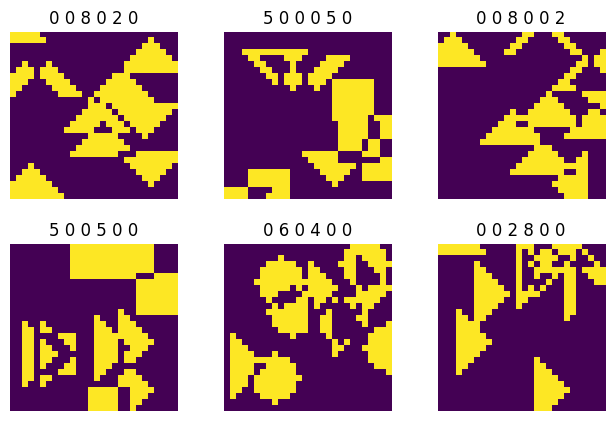

---

## 3. Tasks and objectives

You must design a **multitask deep learning system** that:

1. **Classifies** each image into one of **135 possible configurations**, representing:

   * which **two shape classes** appear, and
   * how their counts (1–9) sum to 10.

   → Example: "3 circles + 7 squares" is one configuration class.

2. **Regresses** the number of shapes of each type (a 6-dimensional real-valued output).

3. Combines both objectives in a **joint loss** function (Hint: losses are implemented in PyTorch):


$$ Loss = \text{NLLLoss(classification)} + \lambda_{\text{cnt}} \cdot \text{SmoothL1Loss(regression)}
$$

---

## 4. Model requirements

### Architecture constraints

You must use **exactly this feature extractor (backbone)**:

```python
nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(64 * 28 * 28, 256), nn.ReLU()
)
```

Then add **two separate heads**:

* `head_cls`: outputs log-probabilities for 135 classes
* `head_cnt`: outputs 6 regression values (counts)

The model must return two outputs: `(log_probs, counts)`.

You may add dropout or batch normalization inside the heads, **but you must not modify the backbone**.

---

## 5. Training setup

* Optimizer: **Adam**, learning rate = 1e-3
* Epochs: up to **100** (use **early stopping**)
* Batch sizes: **64** (train), **1000** (validation)
* Device: GPU allowed for Notebook, but your **final code must run on GPU within ~30 minutes**
* Random seed: set `torch.manual_seed(1)` for reproducibility
* Split: **exactly 9,000 train / 1,000 validation**


---

## 6. Data preprocessing and augmentation

You must implement a **PyTorch `Dataset` class** that:

* Reads `labels.csv`
* Loads the corresponding image (from `data/`)
* Returns both:
  * the image (as a tensor)
  * the labels (counts for 6 shapes)
* Optionally applies transformations

### Required augmentations

You must implement **at least three** of the following:

1. Random horizontal flip
2. Random vertical flip
3. Random 90° rotation (must correctly rotate orientation labels: up → right → down → left)
4. Random brightness/contrast (mild)
5. Gaussian noise
6. Random erasing (small areas only)


---

## 7. Evaluation metrics

Implement and report the following metrics on the validation set:

### (a) **Classification (135-way)**

* Top-1 accuracy
* Macro F1-score
* Per-pair accuracy (aggregate by unordered shape pair, e.g. {circle, up})

### (b) **Regression (6-D counts)**

* RMSE per class and overall
* MAE per class and overall

Also plot:

* Training and validation losses
* Validation accuracy and RMSE over epochs

**Important**: This task is not about finding the best architecture; we expect at least 50% accuracy, but achieving results higher than that will not affect the grade for the assignment**.


---

## 8. Experiments and analysis

You must train and compare **three model settings**:

| Setting | Description                                      |
| :------ | :----------------------------------------------- |
| 1       | **Classification-only:** λ_cnt = 0               |
| 2       | **Regression-only:** classification loss ignored |
| 3       | **Multitask:** λ_cnt = with your choose          |

For each experiment:

* Train until early stopping
* Record loss, accuracy, RMSE, and runtime
* Compare results and explain how λ influences learning
* Discuss whether multitask learning improves the main tasks


---

## 9. Final deliverables

You must submit .zip project with:

1. **Code** (`.ipynb` or `.py`) that:

   * Downloads and extracts the dataset
   * Defines dataset, dataloaders, model, loss, training loop, evaluation, and plotting
   * Can run start-to-end without interaction, and finishes within 30 minutes on Colab T4 GPUs
   * Includes three experiment configurations

2. **Report (2–4 pages, PDF)** including:
   * Section on (EDA) Exploratory Data Analysis in your report: no more than 3 graphs or tables describing the data set.
   * Model architecture
   * Description and justification of augmentations
   * Results table (loss, accuracy, RMSE for all runs)
   * Learning curves
   * Discussion on multitask effects

3. **README.md**:

   * Link to Colab version of task for fast replication.
   * Approximate runtime and resource requirements

---

## 10. Grading rubric

Component	Description	Points
1. Implementation correctness	Correct use of the fixed backbone, two-headed model, and proper training loop (classification + regression).	30%
2. Data & augmentations	Proper dataset loading, preprocessing, and at least three augmentations with brief justification.	20%
3. Evaluation & experiments	Correct computation of metrics (accuracy, F1, RMSE) and completion of all three λ configurations (λ=0, regression-only, your choice λ).	30%
4. Report & analysis
A clear separation of concerns (e.g. headers in notebooks, modules in code) and concise 2–4 page report with results tables, learning curves, confusion matrix, and short discussion on multitask effects and error examples.
20%

###### Readability and modularity will be considered within each grading component. Clear structure (headers in notebooks, docstrings, modular code) significantly improves evaluation speed. Emphasize using clear headers to help reviewers navigate efficiently.
---

In [1]:
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-01 17:56:20--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-01 17:56:20--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.08s   

2025-11-01 17:56:21 (68.9 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



## Exploring the Data


✅ Loaded CSV
Total samples: 10000
Columns: ['name', 'squares', 'circles', 'up', 'right', 'down', 'left']

=== Label Distributions ===


,squares,circles,up,right,down,left
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.65740,1.714900,1.653000,1.677000,1.685700,1.612000
std,2.62909,2.656073,2.619557,2.627539,2.641101,2.574979
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000
max,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000



▶ squares value counts:


,count
squares,
0,6721
2,415
3,475
4,493
5,458
6,492
7,463
8,483



▶ circles value counts:


,count
circles,
0,6590
2,486
3,480
4,463
5,487
6,508
7,486
8,500



▶ up value counts:


,count
up,
0,6681
2,501
3,477
4,464
5,465
6,462
7,456
8,494



▶ right value counts:


,count
right,
0,6646
2,480
3,464
4,484
5,494
6,489
7,466
8,477



▶ down value counts:


,count
down,
0,6633
2,500
3,479
4,467
5,456
6,470
7,508
8,487



▶ left value counts:


,count
left,
0,6729
2,484
3,468
4,500
5,480
6,450
7,464
8,425


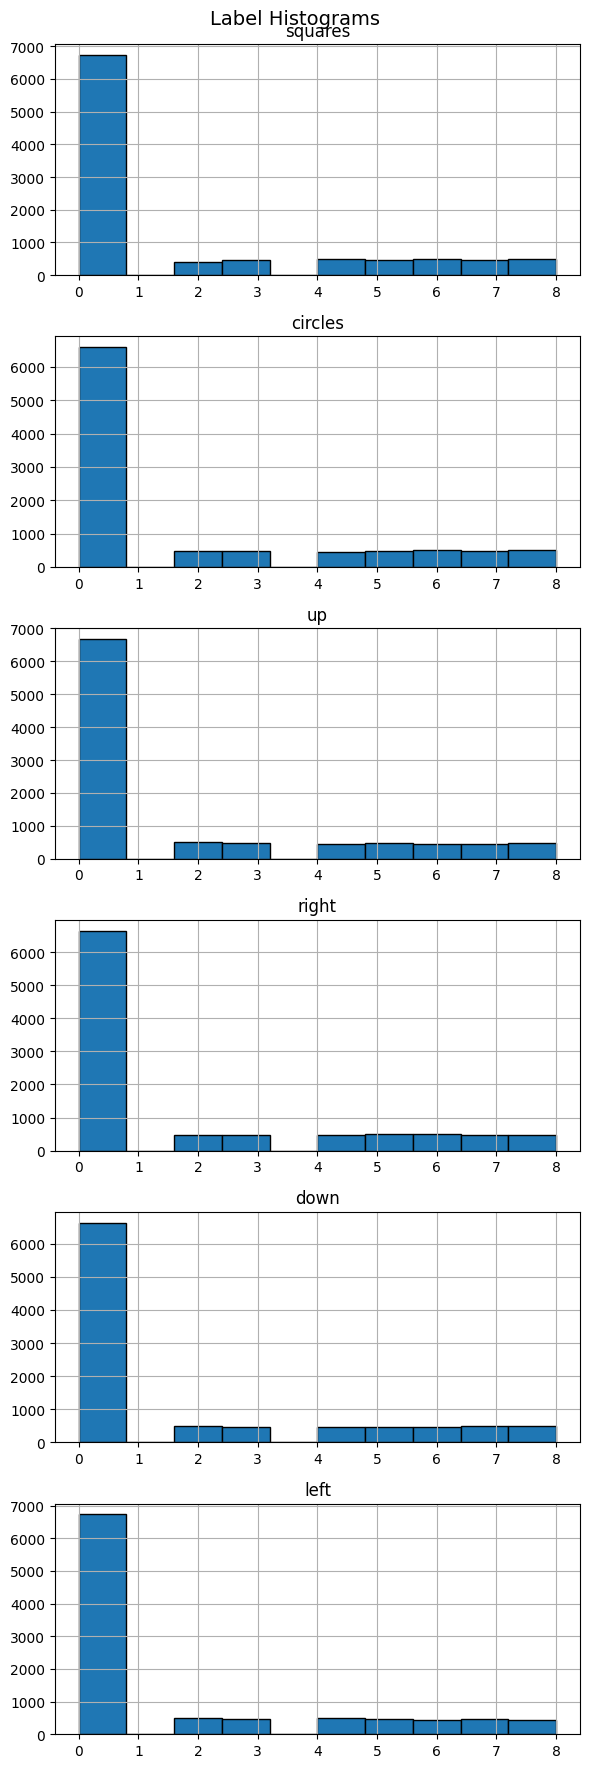

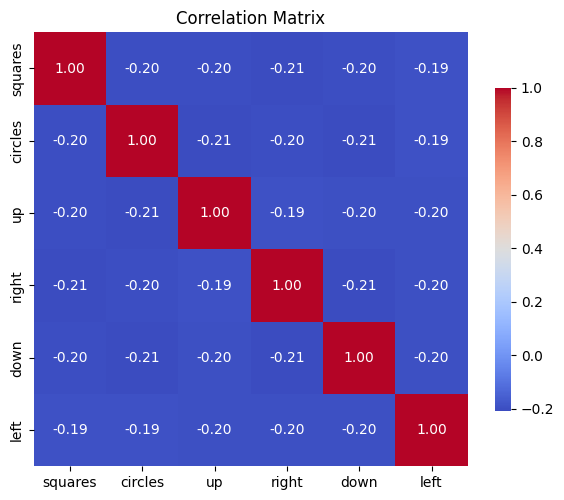

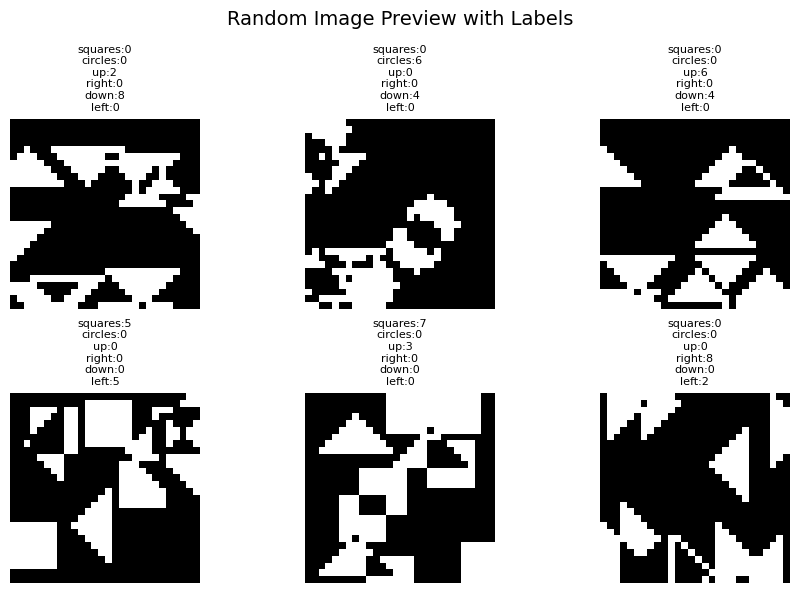


=== Sanity Checks ===
✅ All image paths are valid
✅ No NaN values in labels


In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# ---------------- CONFIG ----------------
CSV_PATH = "./data/labels.csv"
N_PREVIEW = 6               # how many images to preview
IMG_SIZE = 3                # inches per image in preview grid
SEED = 1
# ----------------------------------------

# Load
df = pd.read_csv(CSV_PATH)
IMG_ROOT = Path(CSV_PATH).parent

print("✅ Loaded CSV")
print(f"Total samples: {len(df)}")
print(f"Columns: {list(df.columns)}\n")

# Separate columns
filename_col = df.columns[0]
label_cols = df.columns[1:]

# --------------------- 1) Label counts ---------------------
print("=== Label Distributions ===")
display(df[label_cols].describe(include='all'))

for col in label_cols:
    print(f"\n▶ {col} value counts:")
    display(df[col].value_counts().sort_index())

# --------------------- 2) Histograms ---------------------
fig, ax = plt.subplots(len(label_cols), 1, figsize=(6, 3*len(label_cols)))
fig.suptitle("Label Histograms", fontsize=14)

for i, col in enumerate(label_cols):
    df[col].hist(ax=ax[i], bins=10, edgecolor='k')
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

# --------------------- 3) Correlation heatmap ---------------------
corr = df[label_cols].corr()
plt.figure(figsize=(7, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True, cbar_kws={"shrink": 0.7})
plt.title("Correlation Matrix")
plt.show()

# --------------------- 4) Random sample preview ---------------------
sample_df = df.sample(N_PREVIEW, random_state=SEED)

rows = int(np.ceil(N_PREVIEW / 3))
fig, axes = plt.subplots(rows, 3, figsize=(IMG_SIZE*3, IMG_SIZE*rows))
axes = axes.flatten()

for ax, (_, row) in zip(axes, sample_df.iterrows()):
    img_path = IMG_ROOT / row[filename_col]
    try:
        img = Image.open(img_path).convert("L")
        ax.imshow(img, cmap="gray")
        ax.set_title("\n".join([f"{col}:{row[col]}" for col in label_cols]), fontsize=8)
        ax.axis("off")
    except FileNotFoundError:
        ax.text(0.5, 0.5, "Missing file", ha="center", va="center")
        ax.axis("off")

for ax in axes[len(sample_df):]:
    ax.axis("off")

plt.suptitle("Random Image Preview with Labels", fontsize=14)
plt.tight_layout()
plt.show()

# --------------------- 5) Sanity checks ---------------------
missing = [f for f in df[filename_col] if not (IMG_ROOT / f).exists()]
nan_count = df[label_cols].isna().sum().sum()

print("\n=== Sanity Checks ===")
if missing:
    print(f"⚠️ Missing images: {len(missing)}")
else:
    print("✅ All image paths are valid")

if nan_count > 0:
    print(f"⚠️ NaN values in labels: {nan_count}")
else:
    print("✅ No NaN values in labels")


## Database
Each transform is applied independently with a fixed probability.

In [18]:
import pandas as pd
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms.functional as torchVTF
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1)


class MultitaskDataset(Dataset):

  def __init__(self, root: str, transforms = None, transform_prob: float = 0.3):
    self.root = Path(root)
    self.df = pd.read_csv(root)
    if transforms is None:
      transforms = []
    self.transforms = transforms
    self.transform_prob = transform_prob

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_path = self.root.parent / self.df.iloc[idx, 0]
    image = Image.open(img_path)
    labels = self.df.iloc[idx, 1:].tolist()

    for transform in self.transforms:
      if torch.rand(1) < self.transform_prob:
        image, labels = transform(image, labels)

    image = torchVTF.to_tensor(image)

    return image, torch.tensor(labels, dtype=torch.float32)


def horizontal_flip(image, labels):
  labels[3], labels[5] = labels[5], labels[3]
  return image.transpose(Image.FLIP_LEFT_RIGHT), labels


def vertical_flip(image, labels):
  labels[2], labels[4] = labels[4], labels[2]
  return image.transpose(Image.FLIP_TOP_BOTTOM), labels

def rotation(image, labels):
  labels = [labels[0], labels[1], labels[5], labels[2], labels[3], labels[4]]
  return image.rotate(90), labels

dataset = MultitaskDataset(
    root = './data/labels.csv',
    transforms=[horizontal_flip, vertical_flip, rotation],
    transform_prob=0.1
    )



## Splitting the data

In [20]:
import torch
from torch.utils.data import DataLoader, Subset
import pandas as pd

g = torch.Generator().manual_seed(1)

train_base = MultitaskDataset(
    root="./data/labels.csv",
    transforms=[horizontal_flip, vertical_flip, rotation],
    transform_prob=0.3
)

test_base = MultitaskDataset(
    root="./data/labels.csv",
    transforms=[],
)

n = len(train_base)
perm = torch.randperm(n, generator=g)
split = int(0.9 * n)

train_idx = perm[:split].tolist()
test_idx  = perm[split:].tolist()

assert (len(train_idx), len(test_idx)) == (9000, 1000)

train_ds = Subset(train_base, train_idx)
test_ds  = Subset(test_base,  test_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
